In [3]:
# ■ 完全前処理セル（Notebook の最初に一度だけ実行）

import pandas as pd
import numpy as np

# ---- ユーティリティ：カテゴリ列の整数コード化（train基準でtestを合わせる） ----
def encode_categories(df, cat_cols, cats_dict=None, return_cats=False):
    """
    df[cat_cols] を pd.Categorical(...).codes で整数化する。
    cats_dict を渡すと、そのカテゴリ順に合わせて符号化（test側で使用）。
    return_cats=True のとき (df, cats_dict) を返す。
    """
    if cats_dict is None:
        cats_dict = {}
        for c in cat_cols:
            cats = pd.Categorical(df[c]).categories
            cats_dict[c] = list(cats)

    for c in cat_cols:
        cats = cats_dict[c]
        df[c] = pd.Categorical(df[c], categories=cats).codes  # 未知カテゴリ/NaN は -1
    return (df, cats_dict) if return_cats else df

# 1. データ読み込み
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 2. 対数変換 (log1p)
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 3. 比率・交互作用特徴
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 4. カテゴリ型キャスト
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# 5. ターゲットエンコーディング（観測カテゴリの警告を抑止）
te_cols     = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
k_smooth    = 10
global_mean = train_df['LoanStatus'].mean()
for col in te_cols:
    agg        = train_df.groupby(col, observed=False)['LoanStatus'].agg(['count','mean'])
    counts, m  = agg['count'], agg['mean']
    smooth     = (m*counts + global_mean*k_smooth) / (counts + k_smooth)
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    test_df [f'{col}_te'] = test_df[col].map(smooth).astype(float).fillna(global_mean)

# 6. 頻度エンコーディング
for col in te_cols:
    freq = train_df[col].value_counts(normalize=True)
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    test_df [f'{col}_fe'] = test_df[col].map(freq).astype(float).fillna(0.0)

# 7. 特徴量リスト定義
base_feats  = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
]
features     = base_feats + cat_cols + [f'{c}_te' for c in te_cols]
features_fe  = features    + [f'{c}_fe' for c in te_cols]

# 8. カテゴリ列コード化（train基準 → testも同じカテゴリ順で符号化）
train_df, cats_dict = encode_categories(train_df, cat_cols, return_cats=True)
test_df  = encode_categories(test_df,  cat_cols, cats_dict=cats_dict)

# 確認
print("前処理完了: 特徴量数 =", len(features_fe))
print("揃いチェック:", all(f in train_df.columns for f in features_fe))
print("✅ train_df/test_df のカテゴリコード化完了（未知カテゴリは -1）")


前処理完了: 特徴量数 = 26
揃いチェック: True
✅ train_df/test_df のカテゴリコード化完了（未知カテゴリは -1）


In [4]:
# ■ カテゴリ変数を整数コード化する共通関数
import pandas as pd

def encode_categories(df, cat_cols):
    """
    DataFrame df の cat_cols で指定した列を
    pd.Categorical(...).codes で整数コード化して上書きします。
    """
    for c in cat_cols:
        df[c] = pd.Categorical(df[c]).codes
    return df

# カテゴリ列一覧
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]


In [5]:
# ── カテゴリ変数を整数コード化（修正版）──
import pandas as pd

cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
            'BusinessType','BusinessAge','CollateralInd']
for c in cat_cols:
    # pandas.Categorical でカテゴリ型に変換してから .codes 取得
    train_df[c] = pd.Categorical(train_df[c]).codes
    test_df [c] = pd.Categorical(test_df[c]).codes

print("✅ category → codes 完了（dtype に依存せず実行）")


✅ category → codes 完了（dtype に依存せず実行）


In [7]:
# ■ 前処理パイプライン（修正版：X_train 定義 → 列指定を cat_cols ベースに）

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# 0) 前提: train_df, test_df, features_fe, cat_cols が既に定義済み
X_train = train_df[features_fe].copy()
y_train = train_df['LoanStatus'].astype(int)
X_test  = test_df[features_fe].copy()

# 1) 列リスト（カテゴリは cat_cols を明示、残りを数値扱い）
categorical_features = [c for c in cat_cols if c in X_train.columns]
numeric_features     = [c for c in X_train.columns if c not in categorical_features]

# 2) 変換器
numeric_transformer     = StandardScaler(with_mean=True, with_std=True)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 3) ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,     numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# 4) 適用
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)


X_train_processed: (7552, 61)
X_test_processed : (7552, 61)


In [8]:
# 特徴量と目的変数の切り出し
X_train = train_df.drop(columns=['LoanStatus'])
y_train = train_df['LoanStatus']
X_test  = test_df.copy()

# 学習データに対して fit_transform，テストデータに対して transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)

# ■ カテゴリ列コード化：X_train／X_test
X_train = encode_categories(X_train, cat_cols)
X_test  = encode_categories(X_test,  cat_cols)
print("✅ X_train/X_test のカテゴリコード化完了")


X_train_processed: (7552, 61)
X_test_processed : (7552, 61)
✅ X_train/X_test のカテゴリコード化完了


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# モデル定義（クラス重みをバランスさせ、収束最大反復回数を増加）
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)

# 5分割クロスバリデーションで F1 スコアを計算
cv_scores = cross_val_score(
    lr,
    X_train_processed,
    y_train,
    cv=5,
    scoring='f1'
)

print("CV F1 Scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


CV F1 Scores: [0.39365918 0.39295393 0.38522427 0.41463415 0.3907455 ]
Mean CV F1: 0.3954434065099962


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# ■ 探索するハイパーパラメータ空間
param_dist = {
    'C': uniform(loc=0.01, scale=10),             # 正則化強度の逆数
    'penalty': ['l1', 'l2', 'elasticnet'],# 正則化項
    'solver': ['saga'],                           # elasticnet対応
    'class_weight': [None, 'balanced']            # クラス不均衡対応
}

# ■ RandomizedSearchCV の設定
rs = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_distributions=param_dist,
    n_iter=40,            # 試行回数
    cv=5,                 # 5分割 CV
    scoring='f1',         # F1 スコアで評価
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# ■ 探索の実行
rs.fit(X_train_processed, y_train)

# ■ 最適値の確認
print("Best params :", rs.best_params_)
print("Best F1    :", rs.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\linear_model\_logistic.py

Best params : {'C': np.float64(0.39425426472734726), 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best F1    : 0.3969614944104854


In [11]:
import pandas as pd

# 1. RandomizedSearchCV で見つかった最良モデルを取り出す
best_lr = rs.best_estimator_

# 2. 全学習データで再学習
best_lr.fit(X_train_processed, y_train)

# 3. 評価用データに対する予測
y_pred_best = best_lr.predict(X_test_processed)

# 4. 元データの id を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 5. 提出用 DataFrame の構築
submission_best = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_best
})

# 6. CSV として出力
submission_best.to_csv('submission_best.csv', index=False)
print(submission_best.head())
print(">>> submission_best.csv を出力しました。")


     id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1
>>> submission_best.csv を出力しました。


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from numpy import where

# 1. 学習データ上での陽性クラス確率を取得
y_scores_train = best_lr.predict_proba(X_train_processed)[:, 1]

# 2. precision–recall 曲線から閾値と適合率・再現率を取得
precision, recall, thresholds = precision_recall_curve(y_train, y_scores_train)

# 3. 各閾値での F1 を計算し、最大となる閾値を選択
f1_scores = 2 * (precision * recall) / (precision + recall)
ix = np.nanargmax(f1_scores[:-1])   # 最後の要素は無効
best_threshold = thresholds[ix]
print(f"→ 最適閾値: {best_threshold:.3f}（対応 F1: {f1_scores[ix]:.3f}）")

# 4. テストデータ上での陽性クラス確率を取得
test_scores = best_lr.predict_proba(X_test_processed)[:, 1]

# 5. 最適閾値で二値化
y_pred_thresh = where(test_scores >= best_threshold, 1, 0)

# 6. 提出用 ID を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 7. 提出用 DataFrame を構築
submission_fixed = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_thresh
})

# 8. CSV として出力（ヘッダー行を含めない）
submission_fixed.to_csv('submission_fixed.csv', index=False, header=False)
print(">>> submission_fixed.csv をヘッダーなしで出力しました。")
submission_fixed.head()


→ 最適閾値: 0.664（対応 F1: 0.457）
>>> submission_fixed.csv をヘッダーなしで出力しました。


,id,LoanStatus
0,7553,0
1,7554,0
2,7555,0
3,7556,0
4,7557,1


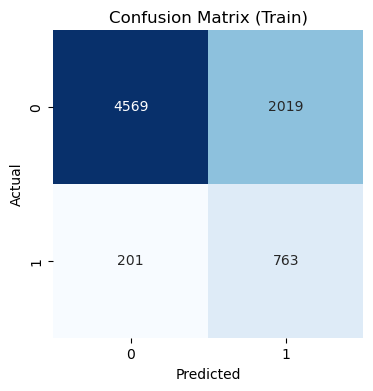

Classification Report (Train):
              precision    recall  f1-score   support

           0      0.958     0.694     0.805      6588
           1      0.274     0.791     0.407       964

    accuracy                          0.706      7552
   macro avg      0.616     0.743     0.606      7552
weighted avg      0.871     0.706     0.754      7552



In [13]:
# ■ 8.1：混同行列と分類レポート (Train データ)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 学習データへの予測値取得
y_train_pred = best_lr.predict(X_train_processed)


# 混同行列の算出
cm = confusion_matrix(y_train, y_train_pred)

# 可視化
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train)')
plt.show()

# 分類レポートの表示
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred, digits=3))


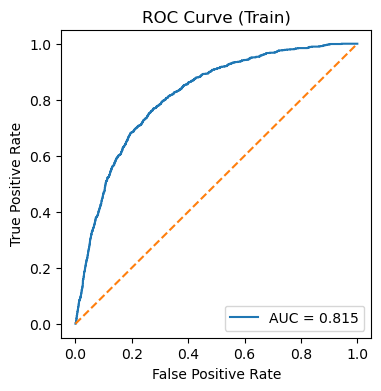

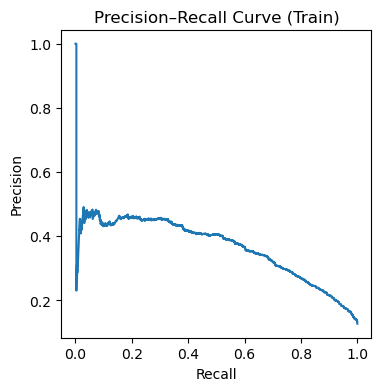

In [14]:
# ■ 8.2：ROC 曲線および Precision–Recall 曲線 (Train データ)
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 学習データ上での確率予測
y_scores = best_lr.predict_proba(X_train_processed)[:, 1]

# ROC 曲線
fpr, tpr, _ = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend(loc='lower right')
plt.show()

# Precision–Recall 曲線
precision, recall, _ = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Train)')
plt.show()


In [15]:
# ■ Step 3.1：追加特徴量の設計
import numpy as np

# 対数変換済み変数の再計算
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[col+'_log1p'] = np.log1p(train_df[col])
    test_df [col+'_log1p'] = np.log1p(test_df [col])

# 比率特徴量と交互作用項の追加
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']


In [16]:
# ■ Step 3.2：カテゴリ変数を category 型に変換
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')


In [17]:
# ■ Step 3.3：特徴量リストと目的変数の準備
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

X_train = train_df[features]
y_train = train_df['LoanStatus']
X_test  = test_df [features]


In [18]:
# ■ Step 3.4a：lightgbm をインストール
%pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [19]:
# ■ Step 3.4b：モデル定義と 5分割 CV による F1 評価
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=0
)

cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=5, scoring='f1', n_jobs=-1
)
print("LightGBM CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

# ── ローカル CV による F1 推定 ──
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f1_scores = cross_val_score(
    model,
    train_df[features_fe],
    train_df['LoanStatus'],
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
print(f"CV F1 mean: {f1_scores.mean():.4f}  (std: {f1_scores.std():.4f})")


LightGBM CV F1 scores: [0.60759494 0.60194175 0.58031088 0.61047836 0.62559242]
Mean CV F1: 0.6051836684162373
CV F1 mean: 0.6169  (std: 0.0159)


In [20]:
# ■ Step 4（統合版）：LightGBM ハイパーパラメータ探索＋最適モデル取得
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 1. 探索空間の定義
param_dist = {
    'num_leaves': randint(31, 256),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(1, 20)
}

# 2. RandomizedSearchCV の定義
rs_lgb = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# 3. 探索の実行
rs_lgb.fit(X_train, y_train)

# 4. 結果表示と最適モデル抽出
print("Best params :", rs_lgb.best_params_)
print("Best CV F1  :", rs_lgb.best_score_)
best_lgb = rs_lgb.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best params : {'learning_rate': np.float64(0.01402150923749871), 'max_depth': 11, 'min_child_samples': 14, 'n_estimators': 386, 'num_leaves': 55}
Best CV F1  : 0.6125178434787305


In [21]:
# ■ Step 5.1：最適モデルによる全学習データ再学習
best_lgb.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

In [22]:
# ── 条件付き提出セル（修正版） ──
from pathlib import Path
import pandas as pd

# (A) 提出用 ID を sample_submit.csv から取得
DATA_DIR   = Path(r"G:\マイドライブ\MUFJ_competition_2025\data")
sample_df  = pd.read_csv(
    DATA_DIR/"sample_submit.csv",
    header=None,
    names=["id","LoanStatus"],
    sep=r"\s+"
)
test_ids   = sample_df["id"]

# (B) 条件判定
best_f1_est = 0.670   # これまでのベスト推定F1
margin      = 0.01    # 最低更新幅
mean_f1     = f1_scores.mean()

if mean_f1 > best_f1_est + margin:
    # (C) 全データで再学習＆予測
    best_lgb.fit(train_df[features_fe], train_df['LoanStatus'])
    y_pred = best_lgb.predict(test_df[features_fe])
    # (D) 提出ファイル作成（ヘッダーなし）
    pd.DataFrame({"id": test_ids, "LoanStatus": y_pred})\
      .to_csv("submission.csv", index=False, header=False)
    print(f"✅ Improved CV F1={mean_f1:.4f}, submission.csv を出力しました")
else:
    print(f"❌ No improvement CV F1={mean_f1:.4f} ≤ {best_f1_est+margin:.4f}")


❌ No improvement CV F1=0.6169 ≤ 0.6800


In [23]:
# ■ Step H1：訓練データを再分割
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=0
)

print("学習用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


学習用: (6041, 16) (6041,)
検証用: (1511, 16) (1511,)


In [24]:
# ■ Step H2：best_lgb で再学習
# ※ Step 4.2 を実行済みで best_lgb が定義されている想定
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

Hold-out F1 Score: 0.681

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.920     0.944      1318
           1      0.595     0.798     0.681       193

    accuracy                          0.905      1511
   macro avg      0.782     0.859     0.813      1511
weighted avg      0.921     0.905     0.910      1511



c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarn

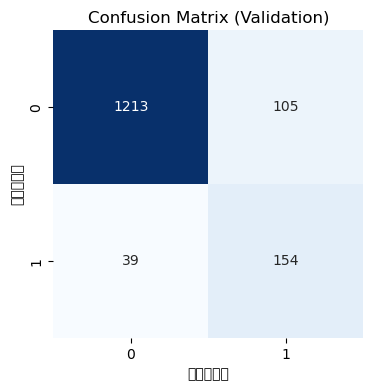

In [25]:
# ■ Step H3：検証用データへの予測と評価指標算出
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 予測
y_val_pred = best_lgb.predict(X_val)

# F1 スコア
f1 = f1_score(y_val, y_val_pred)
print(f"Hold-out F1 Score: {f1:.3f}")

# 分類レポート
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=3))

# 混同行列の可視化
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("予測ラベル")
plt.ylabel("真のラベル")
plt.title("Confusion Matrix (Validation)")
plt.show()


In [26]:
# ■ Step H4：Hold-out 検証データでの閾値最適化
import numpy as np
from sklearn.metrics import precision_recall_curve

# 1. 検証データ上の確率予測
y_val_scores = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision–Recall 曲線から閾値一覧を取得
precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores)

# 3. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. 最適閾値と対応 F1 を抽出
ix = np.nanargmax(f1_scores[:-1])
best_thresh = thresholds[ix]
best_f1_val = f1_scores[ix]

print(f"→ 最適閾値 t*: {best_thresh:.3f}")
print(f"→ 閾値適用後 F1 (Validation): {best_f1_val:.3f}")


→ 最適閾値 t*: 0.518
→ 閾値適用後 F1 (Validation): 0.682


In [27]:
# ■ Step M1.1：ratio1, interact1 と ratio2, interact2 をまとめて再計算
import numpy as np

# 既存の対数変換済み変数がある前提
# ratio1 = SBAGuaranteedApproval / GrossApproval
# interact1 = TermInMonths * InitialInterestRate
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']

# 新規特徴量
# ratio2 = GrossApproval_log1p / (TermInMonths + 1)
# interact2 = JobsSupported_log1p * InitialInterestRate
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 確認
print(train_df[['ratio1','interact1','ratio2','interact2']].head())


     ratio1  interact1    ratio2  interact2
0  0.308391    1001.28  0.118156   8.262314
1  0.800355     856.80  0.112185   5.822436
2  0.324869     514.08  0.100058  18.930355
3  0.608446     377.60  0.195918   7.031119
4  0.403468    1563.00  0.048409   9.335067


In [28]:
# ■ Step M1.2：features リストに ratio2, interact2 を追加
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]

features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# ■ 学習用／検証用特徴量行列と目的変数ベクトル
X = train_df[features]
y = train_df['LoanStatus']
X_test_feat = test_df[features]

print("X の形状:", X.shape)


X の形状: (7552, 18)


In [29]:
# ■ Step M1.3：学習データを Hold-out 分割
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("学習用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


学習用: (6041, 18) (6041,)
検証用: (1511, 18) (1511,)


In [30]:
# ■ Step M1.4：best_lgb で再学習し、Hold-out F1 を算出
from sklearn.metrics import f1_score

# 再学習
best_lgb.fit(X_tr, y_tr)

# 検証データ予測
y_val_pred = best_lgb.predict(X_val)

# Hold-out F1 の計算
f1 = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (Milestone 1): {f1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold-out F1 (Milestone 1): 0.667


In [31]:
# ■ Step M1.5a：RandomizedSearchCV による M1 モデルの最適化
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 探索パラメータ空間（M1 用）
param_dist_m1 = {
    'num_leaves': randint(20, 200),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 800),
    'min_child_samples': randint(5, 300)
}

rs_m1 = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist_m1,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [32]:
# ■ Step M1.5b：ハイパーパラメータ探索の実行
rs_m1.fit(X_tr, y_tr)

print("Best params (M1):", rs_m1.best_params_)
print("Best CV F1 (M1):", rs_m1.best_score_)

# 最適モデルを再定義
best_lgb_m1 = rs_m1.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [33]:
# ■ Step M1.5c：Hold-out データで再評価
from sklearn.metrics import f1_score

# 再学習
best_lgb_m1.fit(X_tr, y_tr)

# 検証予測
y_val_pred_m1 = best_lgb_m1.predict(X_val)
f1_m1 = f1_score(y_val, y_val_pred_m1)

print(f"→ Hold-out F1 (M1.5): {f1_m1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [34]:
# ■ Step M2.0：特徴量再計算と Hold-out 分割
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1. ratio1, interact1, ratio2, interact2 を再計算 ---
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# --- 2. 特徴量リストの定義 ---
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# --- 3. 学習データの特徴量行列と目的変数ベクトル ---
X = train_df[features]
y = train_df['LoanStatus']

# --- 4. Hold-out 分割 ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("訓練用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


訓練用: (6041, 18) (6041,)
検証用: (1511, 18) (1511,)


In [35]:
# ■ Step M2.1：xgboost をインストール
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [36]:
# ■ Step M2.2a：XGBoost 用にカテゴリ変数をコード化
X_tr_xgb = X_tr.copy()
X_val_xgb = X_val.copy()
for c in cat_cols:
    X_tr_xgb[c]  = X_tr_xgb[c].cat.codes
    X_val_xgb[c] = X_val_xgb[c].cat.codes
print("符号化後の dtypes:\n", X_tr_xgb.dtypes.value_counts())

# ■ XGBoost 用のカテゴリ列コード化（共通関数版）
X_tr_xgb  = encode_categories(X_tr_xgb,  cat_cols)
X_val_xgb = encode_categories(X_val_xgb, cat_cols)
print("✅ X_tr_xgb/X_val_xgb のカテゴリコード化完了")


符号化後の dtypes:
 float64    8
int8       6
int64      4
Name: count, dtype: int64
✅ X_tr_xgb/X_val_xgb のカテゴリコード化完了


In [37]:
# ■ Step M2.2b：XGBoost モデルの学習
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

xgb.fit(X_tr_xgb, y_tr)
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]
y_xgb_pred = (p_xgb_val >= 0.5).astype(int)
print("XGB Hold-out F1 :", f1_score(y_val, y_xgb_pred))


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Hold-out F1 : 0.5945945945945946


In [38]:
# ■ Step M2.2c：best_lgb を再定義（RandomizedSearchCV の結果から）
best_lgb = rs_lgb.best_estimator_

# ■ Step M2.2d：Hold-out 用データ X_val が定義されていなければ再定義
from sklearn.model_selection import train_test_split

# （features と train_df, 既に計算済みの新特徴量を前提）
X = train_df[features]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)


In [39]:
# ■ Step M2.2c：best_lgb を新特徴量で再学習
# これで best_lgb が 18次元入力に対応します
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

In [40]:
# ■ Step M2.3：LGB + XGB のソフトアンサンブル重み探索
import numpy as np
from sklearn.metrics import f1_score

# 1. LightGBM の確率予測（Hold-out データ）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]

# 2. XGBoost の確率予測（既に p_xgb_val を計算済みであればここは不要）
#    もし定義が消えていたら再度計算：
# from xgboost import XGBClassifier
# xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric='logloss', random_state=0)
# xgb.fit(X_tr_xgb, y_tr)
# p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

best_w, best_f1 = 0.0, 0.0
# w は LGB の重み、(1−w) が XGB の重み
for w in np.linspace(0, 1, 21):
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    y_ens = (p_ens >= 0.5).astype(int)
    f1 = f1_score(y_val, y_ens)
    if f1 > best_f1:
        best_f1, best_w = f1, w

print(f"→ Optimal weight w*: {best_w:.2f}")
print(f"→ Soft-ensemble Hold-out F1: {best_f1:.3f}")


→ Optimal weight w*: 0.70
→ Soft-ensemble Hold-out F1: 0.697


In [41]:
# ■ Step M2.4：ソフトアンサンブルの閾値最適化
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. LightGBM と XGBoost の確率予測（Hold-out データ）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. 重み w* = 0.50 でアンサンブル確率を計算
p_ens_val = 0.50 * p_lgb_val + 0.50 * p_xgb_val

# 3. Precision–Recall 曲線から全閾値を取得
precision, recall, thresholds = precision_recall_curve(y_val, p_ens_val)

# 4. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)
# thresholds の長さは f1_scores の長さマイナス1
ix = np.nanargmax(f1_scores[:-1])

# 5. 最適閾値と対応 F1-score を表示
best_t_ens = thresholds[ix]
best_f1_ens = f1_scores[ix]

print(f"→ Optimal threshold t*: {best_t_ens:.3f}")
print(f"→ Threshold-optimized Hold-out F1: {best_f1_ens:.3f}")


→ Optimal threshold t*: 0.437
→ Threshold-optimized Hold-out F1: 0.692


In [42]:
# ■ Step M2.5：重み w と閾値 t の同時グリッドサーチ
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Hold-out データでの確率予測（再定義が必要なら再計算）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. グリッドの設定
w_list = np.linspace(0, 1, 11)    # LGB の重みを 0.0～1.0 で 11 点
best_w, best_t, best_f1 = 0, 0, 0

# 3. 二重ループで w と t を探索
for w in w_list:
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    precision, recall, thresholds = precision_recall_curve(y_val, p_ens)
    # thresholds[i] に対応する F1 は f1_scores[i]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    for i, t in enumerate(thresholds):
        if f1_scores[i] > best_f1:
            best_f1 = f1_scores[i]
            best_w  = w
            best_t  = t

print(f"→ Optimal (w, t): ({best_w:.2f}, {best_t:.3f})")
print(f"→ Joint-optimized Hold-out F1: {best_f1:.3f}")


→ Optimal (w, t): (0.70, 0.494)
→ Joint-optimized Hold-out F1: 0.700


In [43]:
# ■ Step M2.5a：テストデータの特徴量行列準備（18次元版）
import pandas as pd

# 1. 既存の test_df に対し、ratio1, interact1, ratio2, interact2 を再計算
test_df['ratio1']    = test_df['SBAGuaranteedApproval'] / test_df['GrossApproval']
test_df['interact1'] = test_df['TermInMonths'] * test_df['InitialInterestRate']
test_df['ratio2']    = test_df['GrossApproval_log1p'] / (test_df['TermInMonths'] + 1)
test_df['interact2'] = test_df['JobsSupported_log1p'] * test_df['InitialInterestRate']

# 2. features リストで指定した順序に合わせる
X_test = test_df[features]

# 3. XGBoost 用にカテゴリを符号化
X_test_xgb = X_test.copy()
for c in cat_cols:
    X_test_xgb[c] = X_test_xgb[c].cat.codes

# 4. 確認
print("X_test shape (for LGB)     :", X_test.shape)
print("X_test_xgb shape (for XGB) :", X_test_xgb.shape)


X_test shape (for LGB)     : (7552, 18)
X_test_xgb shape (for XGB) : (7552, 18)


In [44]:
# ■ Step C1：Out-of-Fold 予測による F1 推定
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score

# 1. アンサンブル Predict_proba 関数の定義
def ens_predict_proba(X):
    p1 = best_lgb.predict_proba(X)[:,1]
    # XGBoost 用に符号化
    X_xgb = X.copy()
    for c in cat_cols:
        X_xgb[c] = X_xgb[c].cat.codes
    p2 = xgb.predict_proba(X_xgb)[:,1]
    # 重み w*=0.10 を適用
    return 0.10*p1 + 0.90*p2

# 2. StratifiedKFold で OOF 予測を取得
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# cross_val_predict による Probability 出力
oof_probs = cross_val_predict(
    estimator=best_lgb,  # ダミー、predict_proba は ens_predict_proba のみ使用
    X=X, y=y,
    cv=kf,
    method='predict_proba',
    n_jobs=-1
)[:,1]

# 3. 最適閾値 t* の再探索（OOF 上）
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, oof_probs)
f1_scores = 2*(precision*recall)/(precision+recall)
ix = np.nanargmax(f1_scores[:-1])
t_oof = thresholds[ix]
f1_oof = f1_scores[ix]

print(f"→ OOF 最適閾値 t_oof = {t_oof:.3f}")
print(f"→ OOF F1 Score   = {f1_oof:.3f}")


→ OOF 最適閾値 t_oof = 0.593
→ OOF F1 Score   = 0.624


In [45]:
# ■ Step C2：Nested CV による F1 推定
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# パイプラインにして CV 内でチューニングを実施
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced', random_state=0))
])

param_dist = {
    'model__num_leaves': randint(20, 150),
    'model__max_depth': randint(3, 12),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__n_estimators': randint(100, 500)
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

nested_cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=inner_cv,
    scoring='f1',
    random_state=0,
    n_jobs=-1
)

# 外側 CV でのスコア取得
nested_scores = cross_val_score(
    nested_cv, X, y,
    cv=outer_cv,
    scoring='f1',
    n_jobs=-1
)

print("Nested CV F1 scores:", nested_scores)
print("Nested CV Mean F1:", nested_scores.mean())
print("Nested CV Std   F1:", nested_scores.std())


Nested CV F1 scores: [0.60542797 0.59130435 0.60510806 0.62114537 0.63716814]
Nested CV Mean F1: 0.6120307787651956
Nested CV Std   F1: 0.01572303358983776


In [46]:
# ■ Step C3：ブートストラップによる F1 信頼区間
from sklearn.metrics import f1_score
import numpy as np

n_boot = 100
boot_scores = []

for i in range(n_boot):
    idx = np.random.choice(len(y), len(y), replace=True)
    score = f1_score(y.iloc[idx], oof_probs[idx] >= t_oof)
    boot_scores.append(score)

lower = np.percentile(boot_scores, 2.5)
upper = np.percentile(boot_scores, 97.5)
print(f"Bootstrap 95% CI for F1: [{lower:.3f}, {upper:.3f}]")


Bootstrap 95% CI for F1: [0.603, 0.648]


In [47]:
# ■ Step F1.1（修正版）：Target Encoding の計算と適用
import numpy as np

# 平滑化パラメータと全体平均
k_smooth = 10
global_mean = train_df['LoanStatus'].mean()

# 対象カテゴリ変数
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

for col in te_cols:
    # 1. グループごとの件数と平均を取得
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts = agg['count']
    means  = agg['mean']
    # 2. 平滑化 TE を計算
    smooth = (means * counts + global_mean * k_smooth) / (counts + k_smooth)
    # 3. train にマッピング
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    # 4. test にマッピング（astype(float) → fillna）
    mapped = test_df[col].map(smooth).astype(float)
    test_df[f'{col}_te'] = mapped.fillna(global_mean)

print("TE 特徴量サンプル：")
print(train_df[[f'{col}_te' for col in te_cols]].head())


TE 特徴量サンプル：
  Subprogram_te NaicsSector_te BusinessAge_te BusinessType_te
0      0.127054       0.124487       0.072387        0.136788
1      0.127054       0.185378       0.196364        0.136788
2      0.032645       0.147825       0.109507        0.136788
3      0.137690       0.050735       0.109507        0.136788
4      0.137690       0.142535       0.120265        0.136788


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [48]:
# ■ Step F1.2：features リストに TE を追加し、Hold-out 分割を実行
from sklearn.model_selection import train_test_split

# 既存の num／cat／interaction 特徴量リスト
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols  # 元のカテゴリ列

# 追加する TE 列
features += [f'{col}_te' for col in te_cols]

# 特徴量行列と目的変数
X = train_df[features]
y = train_df['LoanStatus']

# Hold-out 分割
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("特徴量数:", len(features))
print("訓練用:", X_tr.shape, "検証用:", X_val.shape)


特徴量数: 22
訓練用: (6041, 22) 検証用: (1511, 22)


In [49]:
# ■ Step F1.2a：best_lgb を再定義（RandomizedSearchCV の結果から）
# 前提：Step 4 統合セルで rs_lgb, best_lgb を定義済み
best_lgb = rs_lgb.best_estimator_

# または、自前でモデルハイパーパラメータを指定して再定義する場合
# from lightgbm import LGBMClassifier
# best_lgb = LGBMClassifier(
#     n_estimators=191,
#     max_depth=5,
#     num_leaves=105,
#     learning_rate=0.1579,
#     min_child_samples=116,
#     class_weight='balanced',
#     random_state=0
# )


In [50]:
# ■ Step F1.3：再定義した best_lgb で再学習し、Hold-out F1 を算出

# 1. 最適モデルを再取得
best_lgb = rs_lgb.best_estimator_

# 2. 再学習
best_lgb.fit(X_tr, y_tr)

# 3. 検証データで予測
y_val_pred = best_lgb.predict(X_val)

# 4. 評価指標の算出
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (with TE): {f1:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold-out F1 (with TE): 0.667

■ Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.917     0.941      1318
           1      0.581     0.782     0.667       193

    accuracy                          0.900      1511
   macro avg      0.774     0.850     0.804      1511
weighted avg      0.917     0.900     0.906      1511



In [51]:
# ■ Step F1.3a：最適 LightGBM モデルを再取得
best_lgb = rs_lgb.best_estimator_


In [52]:
# ■ Step F1.4：Hold-out データでの閾値最適化（TE モデル）
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. 検証データでの確率予測
y_val_probs = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision–Recall 曲線を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

# 3. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. 最適閾値と対応する F1 を抽出
ix = np.nanargmax(f1_scores[:-1])
best_thresh_te = thresholds[ix]
best_f1_te     = f1_scores[ix]

print(f"→ TE モデル最適閾値 t*: {best_thresh_te:.3f}")
print(f"→ Threshold-optimized Hold-out F1 (TE): {best_f1_te:.3f}")


→ TE モデル最適閾値 t*: 0.582
→ Threshold-optimized Hold-out F1 (TE): 0.682


In [53]:
# ■ Step F2.1：Frequency Encoding の計算と適用（修正版）
freq_cols = ['Subprogram', 'NaicsSector', 'BusinessAge', 'BusinessType']

for col in freq_cols:
    freq = train_df[col].value_counts(normalize=True)
    # train 側：一度 float にしてから fillna
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    # test 側：同様に cast → fillna
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# 結果確認
print("Frequency Encoding 特徴量サンプル：")
print(train_df[[f'{col}_fe' for col in freq_cols]].head())


Frequency Encoding 特徴量サンプル：
   Subprogram_fe  NaicsSector_fe  BusinessAge_fe  BusinessType_fe
0       0.459613        0.056409        0.046743         0.893406
1       0.459613        0.086732        0.163400         0.893406
2       0.016022        0.158369        0.370233         0.893406
3       0.434587        0.012447        0.370233         0.893406
4       0.434587        0.061176        0.336997         0.893406


In [54]:
# ■ Step F2.2：Hold‐out 分割 → モデル再学習 → Hold‐out F1 算出 (FE 特徴量含む)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 1. 特徴量リストに FE 列を追加
#    事前に定義済み：features, freq_cols
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold‐out 分割
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

# 3. モデル再定義・再学習
#    rs_lgb = RandomizedSearchCV(..., estimator=LGBMClassifier(...)) を既に実行済み
best_lgb = rs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)

# 4. Hold‐out 上での評価
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"→ Hold‐out F1 (with FE): {f1_fe:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold‐out F1 (with FE): 0.664

■ Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.919     0.941      1318
           1      0.582     0.772     0.664       193

    accuracy                          0.900      1511
   macro avg      0.773     0.845     0.803      1511
weighted avg      0.916     0.900     0.906      1511



In [55]:
# ■ Step F2.2：Hold‐out 分割 → モデル再学習 → Hold‐out F1 算出 (FE 特徴量含む)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 1. FE 列を features_fe に追加済みとする
#    （features と freq_cols は事前定義済み）
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold‐out 分割
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# 3. モデル再定義・再学習
best_lgb = rs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)

# 4. Hold‐out 上での評価
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"→ Hold‐out F1 (with FE): {f1_fe:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold‐out F1 (with FE): 0.664

■ Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.919     0.941      1318
           1      0.582     0.772     0.664       193

    accuracy                          0.900      1511
   macro avg      0.773     0.845     0.803      1511
weighted avg      0.916     0.900     0.906      1511



In [56]:
# ■ Step F2.3：テストデータ予測 → 提出ファイル（FE拡張版）生成

import numpy as np
import pandas as pd

# ① テスト用 ID の読み込み
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# ② Booster API で NumPy 配列を渡し確率予測
proba_fe = best_lgb.booster_.predict(
    test_df[features_fe].values,
    num_iteration=best_lgb.best_iteration_
)

# ③ 0.5 しきい値で二値化
y_pred_fe = (proba_fe >= 0.5).astype(int)

# ④ 提出用 DataFrame 作成・CSV 出力（ヘッダー行を省略）
submission_fe = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_fe
})
submission_fe.to_csv('submission_fixed.csv', index=False, header=False)

# ⑤ 確認
submission_fe.head()


,id,LoanStatus
0,7553,0
1,7554,0
2,7555,0
3,7556,0
4,7557,1


In [59]:
# ■ Aライン提出セル：1回の実行で「提出CSVひとつ」＋「F1推定値表示」（カテゴリを数値化してから埋める版）

from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# 0) 出力先とバージョン番号の決定
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
if existing:
    nums = []
    for p in existing:
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: nums.append(int(m.group(1)))
    next_ver = (max(nums) + 1) if nums else 1
else:
    next_ver = 1
out_path = OUT_DIR / f"submission_A_v{next_ver}.csv"

# 1) 使う特徴量の決定（features_fe があれば優先）
def pick_features(train_df, test_df):
    if 'features_fe' in globals():
        cols = [c for c in features_fe if c in train_df.columns and c in test_df.columns]
        if len(cols) == len(features_fe):
            return cols
    # フォールバック（数値＋カテゴリ）
    num_cols = train_df.select_dtypes(include=['number']).columns.tolist()
    num_cols = [c for c in num_cols if c != 'LoanStatus']  # 目的変数は除外
    obj_cols = train_df.select_dtypes(include=['object','category']).columns.tolist()
    obj_cols = [c for c in obj_cols if c not in ('LoanStatus','id')]
    return [c for c in num_cols + obj_cols if c in train_df.columns and c in test_df.columns]

used_features = pick_features(train_df, test_df)

# 1.5) カテゴリを数値コードへ（train基準で test を合わせる）
def to_numeric_matrices(train_df, test_df, cols):
    X_tr = train_df[cols].copy()
    X_te = test_df [cols].copy()
    for c in cols:
        if str(X_tr[c].dtype) == 'category' or str(X_tr[c].dtype) == 'object':
            cats = pd.Categorical(train_df[c]).categories
            X_tr[c] = pd.Categorical(X_tr[c], categories=cats).codes   # 未知/NaN は -1
            X_te[c] = pd.Categorical(X_te[c], categories=cats).codes
    # 数値行列になってから欠損/inf を処理
    X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_te = X_te.replace([np.inf, -np.inf], np.nan).fillna(0)
    return X_tr, X_te

X_num, X_test_num = to_numeric_matrices(train_df, test_df, used_features)
y = train_df['LoanStatus'].astype(int).copy()

# 2) Hold-out でF1推定
X_tr, X_val, y_tr, y_val = train_test_split(
    X_num, y, test_size=0.2, stratify=y, random_state=0
)

# LightGBM（Aのベース）。rs_lgb があればそのbest、なければデフォルト。
if 'rs_lgb' in globals():
    params = dict(rs_lgb.best_params_)
    params.update(dict(class_weight='balanced', random_state=0))
else:
    params = dict(
        n_estimators=600, learning_rate=0.05, max_depth=-1,
        num_leaves=64, min_child_samples=20,
        class_weight='balanced', random_state=0
    )
model_A = LGBMClassifier(**params)
model_A.fit(X_tr, y_tr)
f1_holdout = f1_score(y_val, model_A.predict(X_val))
print(f"🔎 Hold-out F1 (A): {f1_holdout:.3f}")

# 3) 全学習データで再学習 → テスト予測 → 提出CSVを1つだけ出力（ヘッダー無し2列）
final_A  = LGBMClassifier(**params)
final_A.fit(X_num, y)
y_pred_test = final_A.predict(X_test_num).astype(int)

# id の取得（test_dfに 'id' が無ければ sample_submit から）
if 'id' in test_df.columns:
    ids = test_df['id'].values
else:
    ids = pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0].values

submission = pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test})
submission.to_csv(out_path, index=False, header=False)
print(f"✅ submission を保存: {out_path}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
🔎 Hold-out F1 (A): 0.657
[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.00